
# iNaturalist Observations Preview

This notebook loads the cached iNaturalist observations stored at `../data/inaturalist_snakes.geojson`.
Run the cells below after refreshing the dataset with `python scripts/fetch_inaturalist.py data/study_area.geojson 31191 data/inaturalist_snakes.geojson`.


In [3]:

from pathlib import Path
import geopandas as gpd

inat_path = Path("../data/inaturalist_snakes.geojson")
study_path = Path("../data/study_area.geojson")

inat_gdf = gpd.read_file(inat_path)
study_gdf = gpd.read_file(study_path)

print(f"Observations loaded: {len(inat_gdf)}")
if inat_gdf.empty:
    print("⚠️ No iNaturalist features are present in the current export. Try refetching with a different taxon or quality grade.")
else:
    display(inat_gdf.head()[[col for col in ["id", "species_guess", "observed_on", "quality_grade"] if col in inat_gdf.columns]])


Observations loaded: 1000


,id,species_guess,observed_on,quality_grade
0,326850421,Gopher Snake,2025-11-16,research
1,326813962,Tiger Rattlesnake,2025-11-16,research
2,326553959,Desert Nightsnake,2025-11-14,research
3,326617713,Gopher Snake,2025-11-14,research
4,326416254,Western Diamond-backed Rattlesnake,2025-11-13,research


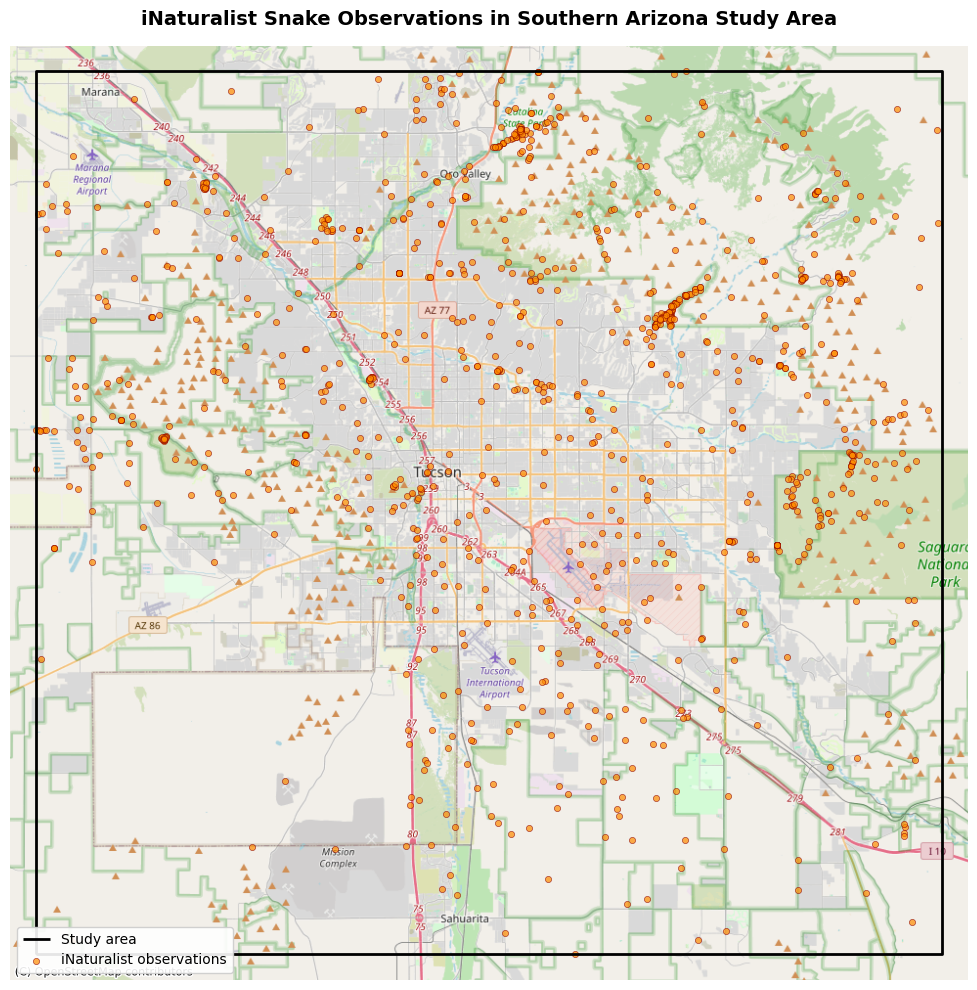

In [4]:

import matplotlib.pyplot as plt
import contextily as ctx

# Reproject to Web Mercator (EPSG:3857) for basemap compatibility
study_gdf_mercator = study_gdf.to_crs(epsg=3857)
if not inat_gdf.empty:
    inat_gdf_mercator = inat_gdf.to_crs(epsg=3857)
else:
    inat_gdf_mercator = inat_gdf.copy()

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot study area boundary first (for extent calculation)
study_gdf_mercator.boundary.plot(ax=ax, color="black", linewidth=2, label="Study area", zorder=3)

if inat_gdf.empty:
    # If no observations, just show study area with basemap
    ax.text(
        0.5,
        0.5,
        "No iNaturalist observations to plot",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=14,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )
    bounds = study_gdf_mercator.total_bounds
else:
    # Plot observations
    inat_gdf_mercator.plot(ax=ax, color="darkorange", markersize=20, alpha=0.7, 
                           edgecolor="darkred", linewidth=0.5, label="iNaturalist observations", zorder=2)
    # Get bounds from both datasets
    bounds = study_gdf_mercator.total_bounds
    inat_bounds = inat_gdf_mercator.total_bounds
    bounds = [
        min(bounds[0], inat_bounds[0]),
        min(bounds[1], inat_bounds[1]),
        max(bounds[2], inat_bounds[2]),
        max(bounds[3], inat_bounds[3])
    ]

# Set axis limits with some padding
ax.set_xlim(bounds[0] - 2000, bounds[2] + 2000)
ax.set_ylim(bounds[1] - 2000, bounds[3] + 2000)

# Add basemap (OpenStreetMap tiles)
try:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=study_gdf_mercator.crs)
except Exception as e:
    print(f"Note: Could not load basemap tiles ({e}). Install contextily with: pip install contextily")
    print("Plotting without basemap background.")

ax.set_title("iNaturalist Snake Observations in Southern Arizona Study Area", 
             fontsize=14, fontweight="bold", pad=15)
ax.set_axis_off()
ax.legend(loc="lower left", framealpha=0.9, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Interactive Map with Folium
import folium
from folium import plugins

# Calculate center of study area
study_center = study_gdf.geometry.centroid
center_lat = study_center.y.mean()
center_lon = study_center.x.mean()

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,
    tiles='OpenStreetMap'
)

# Add study area boundary
if not study_gdf.empty:
    study_geojson = study_gdf.to_json()
    folium.GeoJson(
        study_geojson,
        style_function=lambda feature: {
            'fillColor': 'none',
            'color': 'black',
            'weight': 3,
            'opacity': 0.8
        },
        tooltip=folium.Tooltip("Study Area Boundary"),
        name="Study Area"
    ).add_to(m)

# Add iNaturalist observations
if not inat_gdf.empty:
    # Create a feature group for observations
    obs_group = folium.FeatureGroup(name="iNaturalist Observations")
    
    # Add markers for each observation
    for idx, row in inat_gdf.iterrows():
        lat = row.geometry.y
        lon = row.geometry.x
        
        # Create popup text with observation details
        popup_text = f"<b>Species:</b> {row.get('species_guess', 'Unknown')}<br>"
        if 'observed_on' in row:
            popup_text += f"<b>Date:</b> {row['observed_on']}<br>"
        if 'quality_grade' in row:
            popup_text += f"<b>Quality:</b> {row['quality_grade']}<br>"
        if 'id' in row:
            popup_text += f"<b>iNaturalist ID:</b> {row['id']}"
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=folium.Popup(popup_text, max_width=200),
            color='darkred',
            fillColor='darkorange',
            fillOpacity=0.7,
            weight=1
        ).add_to(obs_group)
    
    obs_group.add_to(m)
else:
    # Add a message if no observations
    folium.Marker(
        [center_lat, center_lon],
        popup="No iNaturalist observations available",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add fullscreen button
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)

# Display the map
m
